In [37]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean.cm as cmo
from scipy.interpolate import griddata
from datetime import datetime, timedelta
import gsw
import datetime
import cartopy.crs as ccrs
from pathlib import Path
import cmasher as cmr
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from skimage.morphology import dilation
from skimage.morphology import disk
xr.set_options(keep_attrs=True)
plt.rcParams['font.size']=14

In [3]:
#EVD
ds01i=xr.open_mfdataset('../../Maud12_sensitivityruns/EXP_REF_intel/Vort_ice_*_julytosep_EXP_REF_intel.nc')
ds01u=xr.open_mfdataset('../../Maud12_sensitivityruns/EXP_REF_intel/u_245*_julytosep_EXP_REF_intel.nc')

ds03i=xr.open_mfdataset('../../Maud12_sensitivityruns/EXP_mfc_ori/Vort*julytosep_EXP_mfc_ori.nc')
ds03u=xr.open_mfdataset('../../Maud12_sensitivityruns/EXP_mfc_ori/u_245*julytosep_EXP_mfc_ori.nc')
ds04i=xr.open_mfdataset('../../Maud12_sensitivityruns/EXP_mfc_mod/Vort*julytosep_EXP_mfc_mod.nc')
ds04u=xr.open_mfdataset('../../Maud12_sensitivityruns/EXP_mfc_mod/u_245*julytosep_EXP_mfc_mod.nc')

# Bathymetry
bat=xr.open_dataset('/home/birte/MAUD_RISE_config/maud_v4/m12_mask/1_domain_cfg_50levels_new.nc')
bat.coords['lon']=bat.nav_lon
bat.coords['lat']=bat.nav_lat


In [45]:
bat

<xarray.Dataset>
Dimensions:       (x: 295, y: 270, z: 50)
Coordinates:
    lon           (y, x) float32 -5.083 -5.0 -4.917 -4.833 ... 19.25 19.33 19.42
    lat           (y, x) float32 -70.53 -70.53 -70.53 ... -61.53 -61.53 -61.53
Dimensions without coordinates: x, y, z
Data variables: (12/47)
    nav_lon       (y, x) float32 -5.083 -5.0 -4.917 -4.833 ... 19.25 19.33 19.42
    nav_lat       (y, x) float32 -70.53 -70.53 -70.53 ... -61.53 -61.53 -61.53
    nav_lev       (z) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
    jpiglo        int32 295
    jpjglo        int32 270
    jpkglo        int32 50
    ...            ...
    mask_tc       (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    mask_tr_all   (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    mask_tr       (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    mask_ha       (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    mask_ha_all   (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    mask_hatr     (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [4]:
ds01i.coords['glamt']=bat.glamt.swap_dims({'x':'x_c','y':'y_c'})
ds01i.coords['gphit']=bat.gphit.swap_dims({'x':'x_c','y':'y_c'})
ds03i.coords['glamt']=bat.glamt.swap_dims({'x':'x_c','y':'y_c'})
ds03i.coords['gphit']=bat.gphit.swap_dims({'x':'x_c','y':'y_c'})
ds04i.coords['glamt']=bat.glamt.swap_dims({'x':'x_c','y':'y_c'})
ds04i.coords['gphit']=bat.gphit.swap_dims({'x':'x_c','y':'y_c'})

In [5]:
ds01u.coords['depth']=(bat.e3t_1d.cumsum(dim='z')- 0.5*bat.e3t_1d.isel(z=0)).swap_dims({'z':'z_c'})
ds03u.coords['depth']=(bat.e3t_1d.cumsum(dim='z')- 0.5*bat.e3t_1d.isel(z=0)).swap_dims({'z':'z_c'})
ds04u.coords['depth']=(bat.e3t_1d.cumsum(dim='z')- 0.5*bat.e3t_1d.isel(z=0)).swap_dims({'z':'z_c'})

In [ ]:
bat=xr.open_dataset('/home/birte/MAUD_RISE_config/maud_v4/m12_mask/1_domain_cfg_50levels_new.nc')
bat.coords['nav_lon']=bat.nav_lon
bat.coords['nav_lat']=bat.nav_lat
bat['mask_tc']=np.zeros((len(bat.y),len(bat.x)))*(bat.bathy_meter.where(bat.bathy_meter<2500))+1
bat['mask_tc']=bat.mask_tc.where(((bat.mask_tc==1)&(bat.glamt<4.3)&(bat.glamt>0.5)&(bat.gphit>-65.5)),other=0)
mask_tc=bat.mask_tc
mask_tc.load()
mask_tc[173,98]=1
mask_tc[178,109]=0

bat['mask_tc']=mask_tc

mean_bathy = bat.bathy_meter.rolling(x=13,center=True).mean().rolling(y=13,center=True).mean()
bat['mask_tr_all']=np.zeros((len(bat.y),len(bat.x)))*(mean_bathy.where(mean_bathy<3500))+1
bat['mask_tr_all']=bat.mask_tr_all.where(((bat.mask_tr_all==1)&(bat.glamt<8)&(bat.gphit>-66.5)),other=0)
bat['mask_tr']=bat.mask_tr_all-bat.mask_tc

mask_tr=bat.mask_tr


bat['mask_ha'] = xr.DataArray(dilation(bat.mask_tr_all, disk(14)) - bat.mask_tr_all,dims=('y', 'x'))
bat['mask_ha']=bat.mask_ha.where(((bat.mask_ha==1)&(bat.bathy_meter<5000)),other=0)
bat['mask_ha_all'] = bat.mask_ha+bat.mask_tr_all
bat['mask_hatr'] = bat.mask_ha+bat.mask_tr
mask_ha=bat.mask_ha
mask_ha=mask_ha.rename("mask_ha")


In [74]:
ds_dc= xr.Dataset(
    data_vars=dict(
              bathy_u=(["y","x"], bat.bathy_meter.data),
              mask_tc_u=(["y","x"], bat.mask_tc.data),
              mask_fl_u=(["y","x"], bat.mask_hatr.data)
        
              ),
    coords=dict(
              x=(["x"],bat.lon.isel(y=0).data),
              y=(["y"],bat.lat.isel(x=0).data)
              )
)

ds_dc = ds_dc.assign_coords({
     "lat": (["y", "x"],bat.lat.data),
     "lon": (["y", "x"],bat.lon.data)
})
#dsi = ds_dc.interp(y=bat.gphiu, x=bat.glamu)
dsi = ds_dc.interp(y=ds03u.gphiu, x=ds03u.glamu)
dsi

<xarray.Dataset>
Dimensions:    (y_c: 270)
Coordinates:
    lat        (y_c) float64 -70.53 -70.5 -70.47 -70.45 ... -61.61 -61.57 -61.53
    lon        (y_c) float64 2.458 2.458 2.458 2.458 ... 2.458 2.458 2.458 2.458
    y          (y_c) float64 -70.53 -70.5 -70.47 -70.45 ... -61.61 -61.57 -61.53
    x          (y_c) float64 2.458 2.458 2.458 2.458 ... 2.458 2.458 2.458 2.458
    x_f        float64 90.5
  * y_c        (y_c) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
    glamu      (y_c) float64 dask.array<chunksize=(270,), meta=np.ndarray>
    gphiu      (y_c) float64 dask.array<chunksize=(270,), meta=np.ndarray>
Data variables:
    bathy_u    (y_c) float64 7.168 7.168 7.168 ... 5.309e+03 5.288e+03 5.309e+03
    mask_tc_u  (y_c) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    mask_fl_u  (y_c) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0

In [77]:
tc=np.where(ds_dc.mask_tc_u==1)[0]
fl=np.where(ds_dc.mask_fl_u==1)[0]
print(tc[0],tc[-1])
print(fl[0],fl[-1])

164 204
126 223


/home/birte/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/birte/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/birte/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/birte/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/birte/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/birte/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out

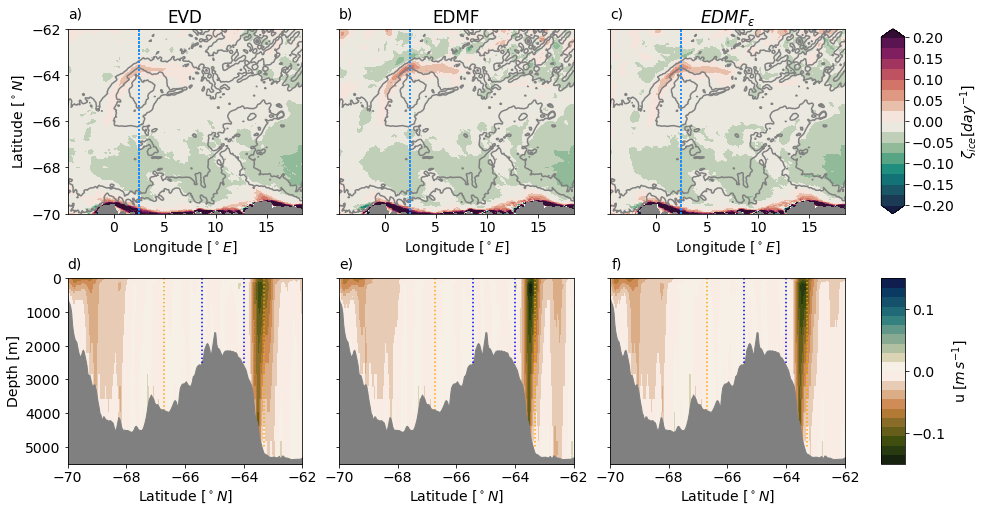

In [95]:
fig,axes=plt.subplots(2,4,figsize=(15,8),gridspec_kw={'width_ratios':[1,1,1,0.1],'hspace':0.35})

# plot winter mean sea ice vorticity ( july to september mean, 2007-2017)
lev=17
wmin=-.2
wmax=-1*wmin
cmapi=cmo.curl
ax=axes[0,0]
ds01i.vort_ice_ym.mean(dim='year').plot.pcolormesh(x="glamt",y="gphit",vmin=wmin,vmax=wmax,levels=lev,cmap=cmapi,ax=ax,add_colorbar=False)
bat.bathy_meter.plot.contour(x="lon",y="lat",ax=ax,levels=[2500,3500,5000],colors='grey')
bat.bathy_meter.where(bat.bathy_meter<1).plot.contourf(x="lon",y="lat",ax=ax,colors='gray',add_colorbar=False)
ax.vlines(x=ds01u.glamu,ymin=-70,ymax=-62,color='dodgerblue',linestyle=':')
ax.set_xlim((-4.5,18.5))
ax.set_ylim(-70,-62)
ax.set_title('EVD')
ax.set_ylabel('Latitude [$^\circ N$]')
ax.set_xlabel('Longitude [$^\circ E$]')
ax.text(0.03, 1.08, 'a)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize='14')

ax=axes[0,1]
cbi=ds03i.vort_ice_ym.mean(dim='year').plot.pcolormesh(x="glamt",y="gphit",vmin=wmin,vmax=wmax,levels=lev,cmap=cmapi,ax=ax,add_colorbar=False)
bat.bathy_meter.plot.contour(x="lon",y="lat",ax=ax,levels=[2500,3500,5000],colors='grey')
bat.bathy_meter.where(bat.bathy_meter<1).plot.contourf(x="lon",y="lat",ax=ax,colors='gray',add_colorbar=False)
ax.vlines(x=ds03u.glamu,ymin=-70,ymax=-62,color='dodgerblue',linestyle=':')
ax.set_xlim((-4.5,18.5))
ax.set_ylim(-70,-62)
ax.set_title('EDMF')
ax.set_yticklabels('')
ax.set_xlabel('Longitude [$^\circ E$]')
ax.set_ylabel('')
ax.text(0.03, 1.08, 'b)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize='14')


ax=axes[0,2]
ds04i.vort_ice_ym.mean(dim='year').plot.pcolormesh(x="glamt",y="gphit",vmin=wmin,vmax=wmax,levels=lev,cmap=cmapi,ax=ax,add_colorbar=False)
bat.bathy_meter.plot.contour(x="lon",y="lat",ax=ax,levels=[2500,3500,5000],colors='grey')
bat.bathy_meter.where(bat.bathy_meter<1).plot.contourf(x="lon",y="lat",ax=ax,colors='gray',add_colorbar=False)
ax.vlines(x=ds04u.glamu,ymin=-70,ymax=-62,color='dodgerblue',linestyle=':')
ax.set_title('$EDMF_{\\epsilon}$')
ax.set_xlabel('Longitude [$^\circ E$]')
ax.set_ylabel('')
ax.set_xlim((-4.5,18.5))
ax.set_ylim(-70,-62)
ax.set_yticklabels('')
plt.colorbar(cbi,cax=axes[0,3],label='$\zeta_{ice} [day^{-1}$]')
ax.text(0.03, 1.08, 'c)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize='14')

# plot velocity section ( july to september mean, 2007-2017)
ulev=21
umin=-.15
umax=-1*umin
cmapu=cmo.tarn
ax=axes[1,0]
ds01u.u_245e_wm.mean(dim='year').plot.pcolormesh(x="gphiu",y="depth",ax=ax,vmin=umin,vmax=umax,levels=ulev,cmap=cmapu,add_colorbar=False)
ax.fill_between(ds01u.gphiu,dsi.bathy_u,6000,color='grey')
ax.vlines(x=ds01u.gphiu.isel(y_c=tc[0]),ymin=0,ymax=2500,color='b',linestyle=':')
ax.vlines(x=ds01u.gphiu.isel(y_c=tc[-1]),ymin=0,ymax=2500,color='b',linestyle=':')
ax.vlines(x=ds01u.gphiu.isel(y_c=fl[0]),ymin=0,ymax=3900,color='orange',linestyle=':')
ax.vlines(x=ds01u.gphiu.isel(y_c=fl[-1]),ymin=0,ymax=5000,color='orange',linestyle=':')
ax.set_ylim(0,5500)
ax.invert_yaxis()
ax.set_xlabel('Latitude [$^\circ N$]')
ax.set_ylabel('Depth [m]')
ax.set_title('')
ax.set_xlim(-70,-62)
ax.text(0.03, 1.08, 'd)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize='14')

ax=axes[1,1]
ds03u.u_245e_wm.mean(dim='year').plot.pcolormesh(x="gphiu",y="depth",ax=ax,vmin=umin,vmax=umax,levels=ulev,cmap=cmapu,add_colorbar=False)
ax.fill_between(ds03u.gphiu,dsi.bathy_u,6000,color='grey')
ax.vlines(x=ds03u.gphiu.isel(y_c=tc[0]),ymin=0,ymax=2500,color='b',linestyle=':')
ax.vlines(x=ds03u.gphiu.isel(y_c=tc[-1]),ymin=0,ymax=2500,color='b',linestyle=':')
ax.vlines(x=ds03u.gphiu.isel(y_c=fl[0]),ymin=0,ymax=3900,color='orange',linestyle=':')
ax.vlines(x=ds03u.gphiu.isel(y_c=fl[-1]),ymin=0,ymax=5000,color='orange',linestyle=':')
ax.set_ylim(0,5500)
ax.invert_yaxis()
ax.set_ylabel('')
ax.set_yticklabels('')
ax.set_xlabel('Latitude [$^\circ N$]')
ax.set_xlim(-70,-62)
ax.set_title('')
ax.text(0.03, 1.08, 'e)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize='14')

ax=axes[1,2]
cbu=ds04u.u245e_wm.mean(dim='year').plot.pcolormesh(x="gphiu",y="depth",ax=ax,vmin=umin,vmax=umax,levels=ulev,cmap=cmapu,add_colorbar=False)
ax.fill_between(ds04u.gphiu,dsi.bathy_u,6000,color='grey')
ax.vlines(x=ds04u.gphiu.isel(y_c=tc[0]),ymin=0,ymax=2500,color='b',linestyle=':')
ax.vlines(x=ds04u.gphiu.isel(y_c=tc[-1]),ymin=0,ymax=2500,color='b',linestyle=':')
ax.vlines(x=ds04u.gphiu.isel(y_c=fl[0]),ymin=0,ymax=3900,color='orange',linestyle=':')
ax.vlines(x=ds04u.gphiu.isel(y_c=fl[-1]),ymin=0,ymax=5000,color='orange',linestyle=':')
ax.set_ylim(0,5500)
ax.invert_yaxis()
ax.set_ylabel('')
ax.set_xlabel('Latitude [$^\circ N$]')
ax.set_xlim(-70,-62)
ax.set_yticklabels('')
ax.set_title('')
ax.text(0.03, 1.08, 'f)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize='14')

plt.colorbar(cbu,cax=axes[1,3],label='u [$m\,s^{-1}$]',ticks=np.arange(-0.1,0.2,0.1))
plt.tight_layout()
plt.savefig('./seaicevort_u_wintermean.jpg',dpi=300)

In [92]:
ds03u

<xarray.Dataset>
Dimensions:    (y_c: 270, year: 11, z_c: 50)
Coordinates:
  * year       (year) int64 2007 2008 2009 2010 2011 ... 2014 2015 2016 2017
  * z_c        (z_c) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    x_f        float64 90.5
  * y_c        (y_c) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
    glamu      (y_c) float64 dask.array<chunksize=(270,), meta=np.ndarray>
    gphiu      (y_c) float64 dask.array<chunksize=(270,), meta=np.ndarray>
    depth      (z_c) float64 0.5112 1.585 2.722 ... 5.499e+03 5.957e+03
Data variables:
    u_245e_wm  (year, z_c, y_c) float32 dask.array<chunksize=(1, 50, 270), meta=np.ndarray>